# Similarity Recomendation System

### **Autor**: 
Miguel Bravo Prieto

--- 

### **Index**

1. [Library load](#id1)
2. [IMDb web scrapper](#id2)
3. [Exploratory Data Analysis (EDA)](#id3)
4. [Natural Language Processing (NLP)](#id4)
5. [Latent Dirichlet Allocation Algorithm (LDA)](#id5)
6. [Collaborative Filtering](#id6)
7. [Display and Result](#id7)
8. [Conclusion](#id8)

---

### **Disclosure**
This notebook is presented as an example for educational purposes on the application of NLP models on recommendation systems. Also, some comments may be in spanish but they only refer to the code.

## Library load<a name="id1"></a>

In [1]:
## Librerías Básicas
import numpy as np
import pandas as pd
# pd.set_option('display.max_colwidth', -1)

import warnings
warnings.filterwarnings('ignore')

## Librerías para visualización
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

import pyLDAvis
import pyLDAvis.gensim

import networkx as nx

## Librerías para Scrapping
from requests import get
from bs4 import BeautifulSoup

import time
from time import sleep
from IPython.core.display import clear_output
from random import randint
from warnings import warn

## Librerías para Preprocesamiento de Datos
from sklearn.base import BaseEstimator, TransformerMixin
import re
import string

from spacy.lang.en.stop_words import STOP_WORDS

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

import gensim
from gensim.parsing.preprocessing import STOPWORDS
from gensim.corpora import Dictionary

## Liberías para Machine Learning
from gensim.models import LdaModel, CoherenceModel
from scipy.spatial import distance

C:\Users\Miguel\Anaconda3\lib\site-packages\networkx\classes\reportviews.py:95: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, Set, Iterable
C:\Users\Miguel\Anaconda3\lib\site-packages\socks.py:58: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Callable
C:\Users\Miguel\Anaconda3\lib\site-packages\thinc\neural\train.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from .optimizers import Adam, SGD, linear_decay
C:\Users\Miguel\Anaconda3\lib\site-packages\thinc\check.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from

## IMDb web scrapper<a name="id2"></a>

In [2]:
## Copiamos la url de las series más populares de IMDb
url = "https://www.imdb.com/chart/tvmeter"

## Realizamos una petición a la página web y añadimos una alerta ante posibles fallos
response = get(url)
if response.status_code != 200:
    warn('Request for series information: Status code: {0}'.format(response.status_code))  

## Parseamos el contenido del html obtenido y filtramos según las clases que nos interesan
html_soup = BeautifulSoup(response.text, 'html.parser')
movie_container = html_soup.find_all("td", class_=("titleColumn","ratingColumn imdbRating"))

## Generamos listas vacias para rellenar con la inforamción
urls = []
names = []
years_begins = []
popular_rankings = []
imdb_ratings = []
popularities_trends = []

for i in range(0,len(movie_container)):
    if i%2==0:
        print("Loop de la serie número", i)
        clear_output(wait=True)
        
        ## Obtenemos el titulo para la URL
        url_titulo = str(movie_container[i].a["href"][7:-1])
        urls.append(url_titulo)
        
        ## Obtenemos el nombre 
        name = str(movie_container[i].a.text).lower()
        names.append(name)
        
        ## Obtenemos el año de comienzo
        if len(movie_container[i].span.text[1:-1]) == 4:
            year_begin = str(movie_container[i].span.text[1:-1])
            years_begins.append(year_begin)
        else:
            year_begin = np.nan
            years_begins.append(year_begin)
            
        ## Obtenemos el ranking de popularidad
        popular_ranking = int(movie_container[i].div.text.split("\n")[0])
        popular_rankings.append(popular_ranking)
        
        ## Obtenemos la tendencia de popularidad
        neg = str(movie_container[i].find("span", class_="global-sprite titlemeter down")) 
        pos = str(movie_container[i].find("span", class_="global-sprite titlemeter up")) 
        tendency = neg + pos

        if "down" in tendency:
            temp="-"
        elif "up" in tendency: 
            temp="+"
        else:
            temp=""
        if "no change" in movie_container[i].div.text:
            trend = movie_container[i].div.text.replace("no change", "0").split("(")[1].split(")")[0]
        else:
            trend = movie_container[i].div.text.replace(",", "").split("\n\n")[1].split(")")[0]
            
        popularity_trend = int(temp + trend)
        popularities_trends.append(popularity_trend)
                              
    if i%2!=0 and len(str(movie_container[i].text)) != 1:
        print("Loop de la serie número", i)
        clear_output(wait=True)

        ## Obtenemos la puntuación de IMDb
        imdb_rating = float(str(movie_container[i].text[1:4]).replace(",","."))
        imdb_ratings.append(imdb_rating)
           
    elif i%2!=0 and len(str(movie_container[i].text)) == 1:
        print("Loop de la serie número", i)
        clear_output(wait=True)

        ## Rellenamos el valor con NaN
        imdb_rating = np.nan
        imdb_ratings.append(imdb_rating)

print("Bucle finalizado")

Bucle finalizado


In [3]:
## Generamos un dataframe con los datos scrapeados
data_series = pd.DataFrame({'urls' : urls,
                            'names' : names,
                            'years_begins' : years_begins,
                            'popular_rankings' : popular_rankings,
                            'popularities_trends' : popularities_trends,
                            'imdb_ratings' : imdb_ratings}, )
print(data_series.info())

data_series.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
urls                   100 non-null object
names                  100 non-null object
years_begins           100 non-null object
popular_rankings       100 non-null int64
popularities_trends    100 non-null int64
imdb_ratings           99 non-null float64
dtypes: float64(1), int64(2), object(3)
memory usage: 4.8+ KB
None


,urls,names,years_begins,popular_rankings,popularities_trends,imdb_ratings
14,tt2661044,los 100,2014,15,4,7.7
64,tt6468322,la casa de papel,2017,65,-9,8.6
26,tt2560140,ataque a los titanes,2013,27,-7,8.8
8,tt4052886,lucifer,2015,9,-2,8.2
67,tt4276624,krypton,2018,68,146,7.1


In [4]:
## Generamos listas vacias para rellenar con la inforamción
users_names = []
users_ratings = []
comments_dates = []
comments_titles = []
users_texts = []
urls_comments = []

requests=0
start_time_title = time.time()

## Creamos un bucle
for url_title in urls:
    url = "https://www.imdb.com/title/"+url_title+"/reviews"
    
    ## Realizamos una petición a la página web y añadimos una alerta ante posibles fallos
    response = get(url)
    if response.status_code != 200:
        warn('Request for new serie: {0}; Status code: {1}'.format(requests, response.status_code))    
    
    ## Generamos un tiempo de espera entre peticiones y controlamos la frecuencia de estas
    requests += 1
    sleep(randint(1,3))
    elapsed_time = time.time() - start_time_title
    print('Request for new serie: {0}; Frequency: {1:.4} requests/s'.format(requests, requests/elapsed_time))
    clear_output(wait=True)    
    
    ## Parseamos el contenido del html obtenido y filtramos según las clases que nos interesan
    html_soup = BeautifulSoup(response.text, 'html.parser')
    comment_container = html_soup.find_all("div", class_=("header", "review-container", "load-more-data"))

    ## Obtenemos el número de comentarios totales
    number_comments = int(str(comment_container[0].div.text).replace(",","").replace("Reviews",""))
   
    ## Iniciamos parametros del bucle
    n1=1
    n2=0
    requests_ajax=0
    start_time_comment = time.time()
    length = len(comment_container)-2
    flag = True
    
    ## Obtenemos la URL-AJAX
    data_ajaxurl = comment_container[length]["data-ajaxurl"]

    ## Creamos un bucle anidado
    while (n2 < number_comments and flag):        
        for i in range(n1, length):
            n2+=1
            ## Obtenemos la puntuación del usuario
            if comment_container[i].find("span", class_="rating-other-user-rating") is not None:
                user_rating = int(comment_container[i].find("span", class_="rating-other-user-rating").span.text)
                users_ratings.append(user_rating)

                ## Obtenemos el nombre del usuario
                user_name = comment_container[i].find("span", class_="display-name-link").text
                users_names.append(user_name)

                ## Obtenemos la fecha del comentario
                comment_date = comment_container[i].find("span", class_="review-date").text
                comments_dates.append(comment_date)

                ## Obtenemos el titulo del comentario
                comment_title = comment_container[i].find(class_="title").text[1:-1]
                comments_titles.append(comment_title)

                ## Obtenemos el comentario del usuario
                user_text = comment_container[i].find(class_="text show-more__control").text
                users_texts.append(user_text)

                ## Añadimos la url del titulo
                urls_comments.append(url_title)
        
        ## Obtenemos la key de la URL-AJAX
        if "data-key" in str(comment_container[length]):
            data_key= comment_container[length]["data-key"]
            
            ## Generamos la nueva URL con más comentarios
            new_url = "http://www.imdb.com/{0}?paginationKey={1}".format(data_ajaxurl, data_key)
        
            ## Realizamos una petición a la página web y añadimos una alerta ante posibles fallos
            response = get(new_url)
            if response.status_code != 200:
                warn('Request for more comments: {0}.{1}; Status code: {2}'.format(requests, requests_ajax, response.status_code))    
        
            ## Generamos un tiempo de espera entre peticiones y controlamos la frecuencia de estas
            requests_ajax += 1
            sleep(randint(1,3))
            elapsed_time = time.time() - start_time_comment
            print('Request for comments: {0}.{1}; Frequency: {2:.4} requests/s'.format(requests, requests_ajax, requests_ajax/elapsed_time))
            clear_output(wait=True)

            ## Parseamos el contenido del html obtenido y filtramos según las clases que nos interesan
            html_soup = BeautifulSoup(response.text, 'html.parser')
            comment_container = html_soup.find_all("div", class_=("review-container", "load-more-data"))

            ## Actualizamos los parametros del bucle
            length = len(comment_container)-1
            n1=0   

        else:
            flag = False

print("Bucle finalizado", "\n")

Bucle finalizado 



In [5]:
## Generamos un dataframe con los datos scrapeados
data_comments = pd.DataFrame({'urls' : urls_comments,
                              'users_names' : users_names,
                              'users_ratings' : users_ratings,
                              'comments_dates' : comments_dates,
                              'comments_titles' : comments_titles,
                              'users_texts' : users_texts})

## obtenemos info de las variables y observamos una muestra
print(data_comments.info())
data_comments.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42298 entries, 0 to 42297
Data columns (total 6 columns):
urls               42298 non-null object
users_names        42298 non-null object
users_ratings      42298 non-null int64
comments_dates     42298 non-null object
comments_titles    42298 non-null object
users_texts        42298 non-null object
dtypes: int64(1), object(5)
memory usage: 1.9+ MB
None


,urls,users_names,users_ratings,comments_dates,comments_titles,users_texts
15619,tt8064302,gmthoren66,10,8 May 2019,Loved It!,I watched this show in one sitting! I was goin...
1264,tt7366338,runa-782-785862,10,2 June 2019,Disturbing but so good,Nuclear reactors and radiation can be kind of ...
6656,tt7137906,lc-qt,10,11 June 2019,Ironic and prophetic,I have been profoundly affected by this show. ...
31623,tt6468322,paraskevaidis,10,9 October 2018,One of the best series i have ever seen..,I dont want to give info about the series.. \n...
15044,tt2357547,anowlin24,4,12 March 2018,The 1st season was better.,I didn't care for season 2. Trish got even mor...


In [6]:
## Guardamos los set de datos obtenidos
path = "C:/Users/Miguel/Desktop/Data Science/9 - TFE/Datos/"

print("Tamaño del set de series:", data_series.shape)
print("Tamaño del set de comentarios:", data_comments.shape)

data_series.to_csv(path + "data_series.csv", header=True, sep=";", index=False)
data_comments.to_csv(path + "data_comments.csv", header=True, sep="|", index=False)

print("\nSets de datos guardados")

Tamaño del set de series: (100, 6)
Tamaño del set de comentarios: (42298, 6)

Sets de datos guardados


## Exploratory Data Analysis (EDA)<a name="id3"></a>

---

The variables obtained through the previous scrapping technique are:

1. **urls**: Series identifier code in the url
2. **names**: Name of the series
3. **years_begins**: Year in which the series began
4. **popular_rankings**: Popularity ranking
5. **popularities_trends**: Popularity trend
6. **imdb_ratings**: Average IMDb rating
7. **users_names**: Username
8. **users_ratings**: User Rating
9. **comments_dates**: Date of the comment
10. **comments_titles**: Comment title
11. **users_texts**: Comment text

---

In [7]:
## Cargamos los set de datos guardados
path = "../Datos/"

data_series = pd.read_csv(path + "data_series.csv", header=0, sep=";", dtype={"years_begins":str})
data_comments = pd.read_csv(path + "data_comments.csv", header=0, sep="|", dtype={"users_ratings":float})

print("Sets de datos cargados")

Sets de datos cargados


In [8]:
## Juntamos los datos de las series con los comentarios mediante el nombre de la url
data = data_series.merge(data_comments, how='left', on="urls")

## Obtenemos el número de comentarios por serie
comments_per_serie = data.groupby(["names"])["users_texts"].agg("count").reset_index()
comments_per_serie.columns = ["names","total_comments"]

## Juntamos los datos con el conteo de comentarios por serie mediante el nombre de éstas
data = data.merge(comments_per_serie, how='left', on="names")

## Cambiamos los formatos de algunas variables
data.comments_dates = pd.to_datetime(data.comments_dates)
data.total_comments = data.total_comments.astype("int64")
data["short_dates"] = data.comments_dates.astype(str).apply(lambda x: x[:][0:4])

## obtenemos info de las variables y observamos una muestra
print(data.info())
data.sample(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42299 entries, 0 to 42298
Data columns (total 13 columns):
urls                   42299 non-null object
names                  42299 non-null object
years_begins           42299 non-null object
popular_rankings       42299 non-null int64
popularities_trends    42299 non-null int64
imdb_ratings           42298 non-null float64
users_names            42298 non-null object
users_ratings          42298 non-null float64
comments_dates         42298 non-null datetime64[ns]
comments_titles        42298 non-null object
users_texts            42298 non-null object
total_comments         42299 non-null int64
short_dates            42299 non-null object
dtypes: datetime64[ns](1), float64(2), int64(3), object(7)
memory usage: 4.5+ MB
None


,urls,names,years_begins,popular_rankings,popularities_trends,imdb_ratings,users_names,users_ratings,comments_dates,comments_titles,users_texts,total_comments,short_dates
22898,tt0413573,anatomía de grey,2005,37,1,7.6,caspian1978,6.0,2017-10-03,Life Support,When I began watching Grey's Anatomy I was sin...,332,2017
34876,tt2372162,orange is the new black,2013,79,2,8.1,stuss-13045,10.0,2018-07-09,Awesome!,Overall it's a great show. I got sucked in on ...,312,2018
29227,tt7908628,lo que hacemos en las sombras,2019,53,-2,8.4,diprimak,1.0,2019-05-13,This,This not that funny I have seen the movie and ...,130,2019


In [9]:
## Obtenemos la suma de valores NaN
miss_values = data.isnull().sum()

## Calculamos el porcentaje equivalente a dichas sumas redondeando el resultado
miss_values_percent = (miss_values*100/len(data)).round(2)

## Juntamos ambos calculos en una misma tabla
miss_values_table = pd.concat([miss_values,miss_values_percent], axis=1)

## Renombramos las columnas y filtramos las filas cuyo valor es distinto de 0 para su visualización
miss_values_table = miss_values_table.rename(columns={0:"Total de NaN", 1:"% de NaN"})
miss_values_table[miss_values_table.loc[:,"Total de NaN"] != 0]

,Total de NaN,% de NaN
imdb_ratings,1,0.0
users_names,1,0.0
users_ratings,1,0.0
comments_dates,1,0.0
comments_titles,1,0.0
users_texts,1,0.0


In [10]:
## Eliminamos todas las filas que posean valores NaN.
data = data.dropna(axis=0)

## Contamos los posibles duplicados y los eliminamos
duplicated_rows = data.duplicated().sum()   
if (duplicated_rows > 0):
    data = data.drop_duplicates().reset_index(drop=True)
    print("Número de filas duplicadas eliminadas:", duplicated_rows)
else:
    print("No se han encontrado filas duplicadas")

Número de filas duplicadas eliminadas: 1


In [11]:
## Obtenemos un análisis descriptivo de las variables cuantitativas redondeando el resultado
data.describe().round(2)

,popular_rankings,popularities_trends,imdb_ratings,users_ratings,total_comments
count,42297.00,42297.00,42297.00,42297.00,42297.00
mean,39.82,23.38,8.44,7.46,905.55
std,30.60,185.55,0.90,3.17,878.80
min,1.00,-33.00,3.30,1.00,16.00
25%,14.00,-4.00,8.10,5.00,346.00
50%,32.00,0.00,8.50,9.00,617.00
75%,65.00,4.00,8.90,10.00,1016.00
max,100.00,1701.00,9.60,10.00,3381.00


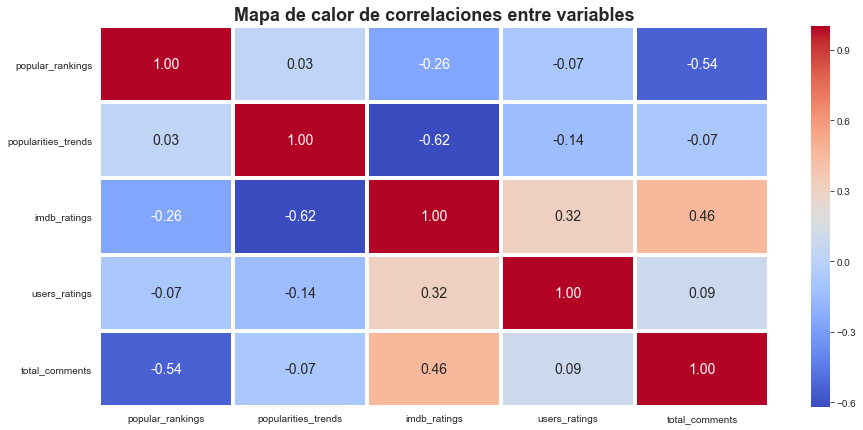

In [12]:
## Generamos una tabla de correlaciones para observar la interacción de las variables cuantitativas
corr= data.corr().round(2)

## Visualizamos estas correlaciones mediante un mapa de calor
fig, ax = plt.subplots(figsize=(15,7))
ax=sns.heatmap(corr, 
               ax=ax,           
               cmap="coolwarm", 
               annot=True, 
               fmt='.2f',       
               annot_kws={"size": 14},
               linewidths=3)

ax.set_title("Mapa de calor de correlaciones entre variables", fontsize=18, fontweight="bold")

plt.show()

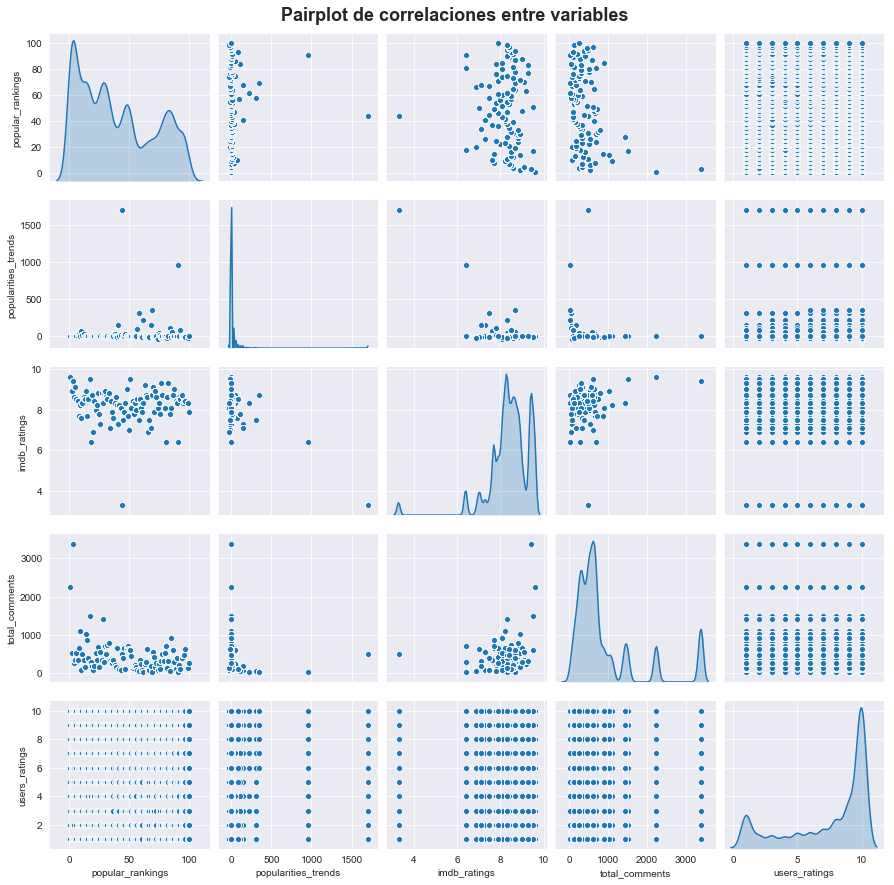

In [13]:
## Generamos un gráfico de tipo pairplot para observar las correlaciones entre variables numéricas
pp = sns.pairplot((data),
              kind="scatter",
              diag_kind="kde",
              height=2.5,
              markers="o",
              vars=["popular_rankings", "popularities_trends", "imdb_ratings", "total_comments", "users_ratings",])

fig = pp.fig 
fig.subplots_adjust(top=0.95, wspace=0.05)
fig.suptitle("Pairplot de correlaciones entre variables", fontsize=18, fontweight="bold")

plt.show()

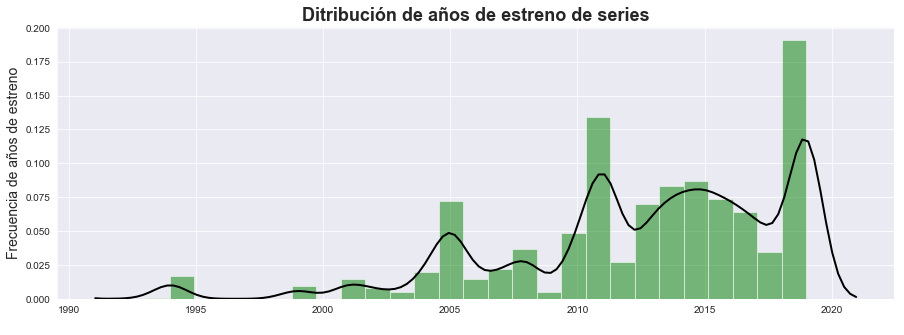

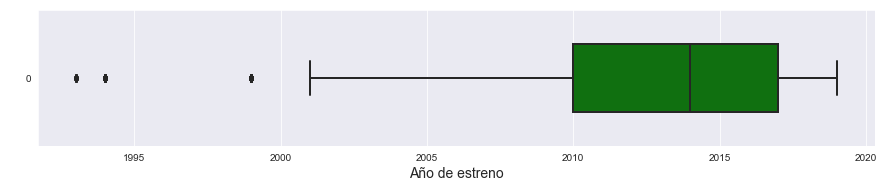

In [14]:
## Generamos un gráfico de frecuencias
fig, ax = plt.subplots(figsize=(15,5))
ax=sns.distplot(data.years_begins.astype(int),
             bins=max(data.years_begins.astype(int))-min(data.years_begins.astype(int))+1,
             hist=True,
             hist_kws={"color": "g", "alpha": 0.5},
             kde=True,          
             kde_kws={"color": "k", "lw": 2})

ax.set_title("Ditribución de años de estreno de series", fontsize=18, fontweight="bold")
ax.set_xlabel(" ")
ax.set_ylabel("Frecuencia de años de estreno", fontsize=14)

## Generamos un gráfico tipo boxplot
fig, ax = plt.subplots(figsize=(15,2.5))
ax=sns.boxplot(data=data.years_begins.astype(int),
               color="g",
               width=0.5,
               linewidth=2,
               orient="h")

ax.set_xlabel("Año de estreno", fontsize=14)
ax.set_ylabel(" ", fontsize=14)

plt.show()

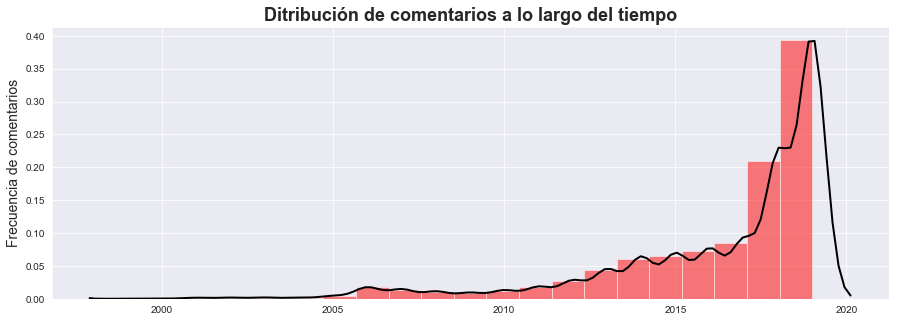

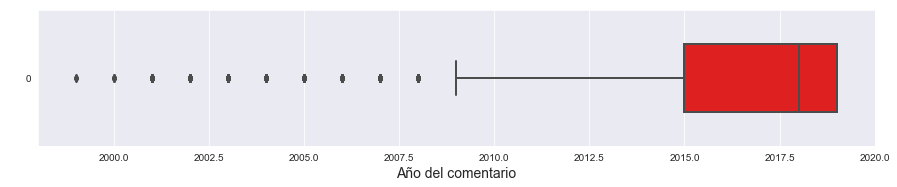

In [15]:
## Generamos un gráfico de frecuencias
fig, ax = plt.subplots(figsize=(15,5))
ax=sns.distplot(data.short_dates.astype(int),
             bins=max(data.short_dates.astype(int))-min(data.short_dates.astype(int))+1,
             hist=True,
             hist_kws={"color": "r", "alpha": 0.5},
             kde=True,          
             kde_kws={"color": "k", "lw": 2})

ax.set_title("Ditribución de comentarios a lo largo del tiempo", fontsize=18, fontweight="bold")
ax.set_xlabel(" ")
ax.set_ylabel("Frecuencia de comentarios", fontsize=14)

## Generamos un gráfico tipo boxplot
fig, ax = plt.subplots(figsize=(15,2.5))
ax=sns.boxplot(data=data.short_dates.astype(int),
               color="r",
               width=0.5,
               linewidth=2,
               orient="h")

ax.set_xlabel("Año del comentario", fontsize=14)
ax.set_ylabel(" ", fontsize=14)

plt.show()

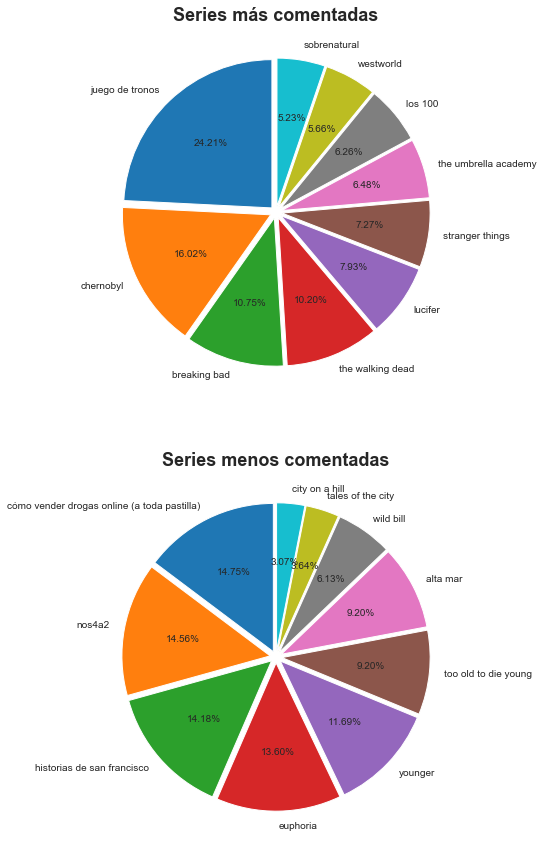

In [16]:
## Descartamos las series que no tienen comentarios
comments_per_serie= comments_per_serie[comments_per_serie.total_comments > 0]

## Ordenamos los datos según el número de comentarios
top10 = comments_per_serie.sort_values(by=["total_comments"], ascending=False).reset_index(drop=True).head(10)
bottom10 = comments_per_serie.sort_values(by=["total_comments"], ascending=False).reset_index(drop=True).tail(10)

## Generamos un subplot e indicamos algunos parametros
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,15))
explode= [0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04]

## Generamos un pie chart de las 10 series con más comentarios
ax1.set_title("Series más comentadas", fontsize=18, fontweight="bold")
ax1.pie(top10["total_comments"],
       labels=top10.names,
       explode=explode,
       autopct="%.2f%%",
       startangle=90)

## Generamos un pie chart de las 10 series con menos comentarios
ax2.set_title("Series menos comentadas", fontsize=18, fontweight="bold")
ax2.pie(bottom10["total_comments"],
       labels=bottom10.names,
       explode=explode,
       autopct="%.2f%%",
       startangle=90)

plt.show()

       popular_rankings  popularities_trends  imdb_ratings
count             10.00                10.00         10.00
mean              23.70                -0.60          8.70
std               24.28                 4.01          0.65
min                1.00                -5.00          7.70
25%               10.25                -3.75          8.22
50%               16.00                -1.00          8.65
75%               31.00                 1.50          9.28
max               85.00                 7.00          9.60 



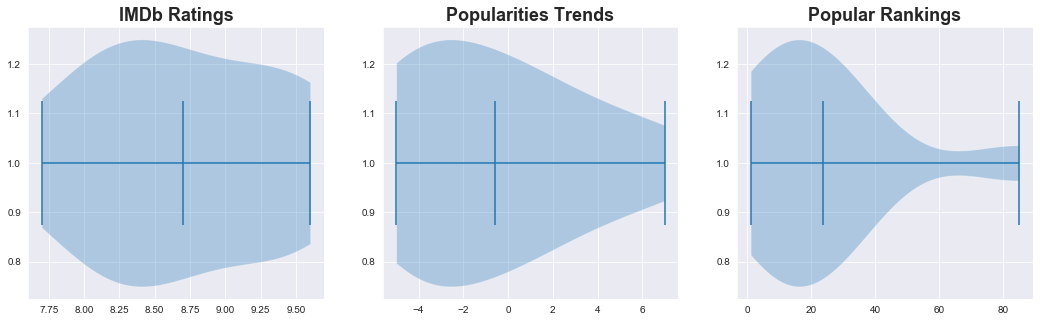

In [17]:
## Generamos un listado de las series en el top10 y obtenemos sus estadísticos
names_list = top10.names.tolist()
top10_data = data_series[data_series["names"].isin(names_list)]
print(top10_data.describe().round(2), "\n")

## Visualizamos la distribución de las variables numéricas
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(18,5))

ax1.violinplot(top10_data.imdb_ratings,vert=False, showmeans=True)
ax1.set_title("IMDb Ratings", fontsize=18, fontweight="bold")

ax2.violinplot(top10_data.popularities_trends, vert=False, showmeans=True)
ax2.set_title("Popularities Trends", fontsize=18, fontweight="bold")

ax3.violinplot(top10_data.popular_rankings, vert=False, showmeans=True)
ax3.set_title("Popular Rankings", fontsize=18, fontweight="bold")

plt.show()

       popular_rankings  popularities_trends  imdb_ratings
count             10.00                10.00         10.00
mean              57.50               211.40          7.55
std               26.37               296.16          0.71
min               10.00               -33.00          6.40
25%               45.25                10.75          7.00
50%               64.00               131.50          7.55
75%               72.75               286.25          8.02
max               91.00               962.00          8.70 



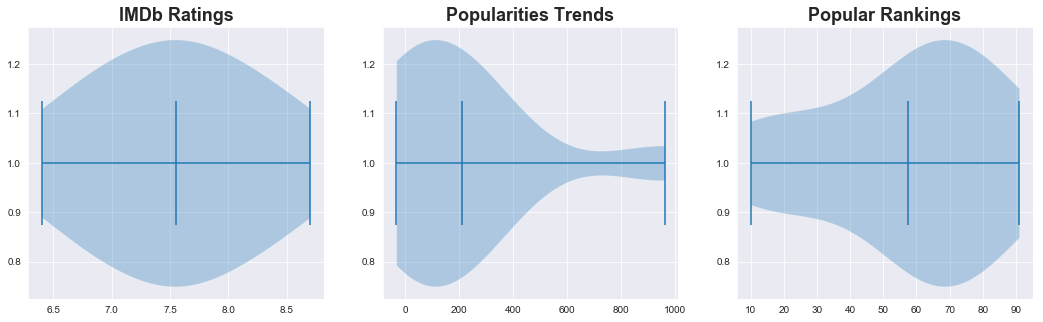

In [18]:
## Generamos un listado de las series en el bottom10 y obtenemos sus estadísticos
names_list = bottom10.names.tolist()
bottom10_data = data_series[data_series["names"].isin(names_list)]
print(bottom10_data.describe().round(2), "\n")

## Visualizamos la distribución de las variables numéricas
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(18,5))

ax1.violinplot(bottom10_data.imdb_ratings,vert=False, showmeans=True)
ax1.set_title("IMDb Ratings", fontsize=18, fontweight="bold")

ax2.violinplot(bottom10_data.popularities_trends, vert=False, showmeans=True)
ax2.set_title("Popularities Trends", fontsize=18, fontweight="bold")

ax3.violinplot(bottom10_data.popular_rankings, vert=False, showmeans=True)
ax3.set_title("Popular Rankings", fontsize=18, fontweight="bold")

plt.show()

## Natural Language Processing (NLP)<a name="id4"></a>

In [19]:
## Seleccionamos las varariables que continen lenguaje natural
text = data.loc[:,("names", "comments_titles", "users_texts")]

## Unimos el titulo del comentario con el texto del comentario de cada usuario
text["all_text"] = np.NAN
text.all_text = text.comments_titles + ". " + text.users_texts

## Generamos un string a modo de documento con todos los textos de cada serie
series_texts = []
n=0
for i in text.names.unique():
    text_union = text[text.names==i].all_text.tolist()
    text_union = " ".join(text_union)
    series_texts.append(i + ". " + text_union)
    
## Creamos un dataframe con todos los textos unidos y el nombre de cada serie
data_NLP = pd.DataFrame({"names":text.names.unique().tolist(),
                         "series_texts":series_texts})

print("Tamaño del DataFrame:", data_NLP.shape)

Tamaño del DataFrame: (99, 2)


In [20]:
warnings.filterwarnings('ignore')

class CleanText(BaseEstimator, TransformerMixin):
   
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def remove_emoji(self, input_text):
        return input_text.encode('ascii', 'ignore').decode('ascii')
  
    def remove_punctuation(self, input_text):
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ') 
        return input_text.translate(trantab)

    def remove_digits(self, input_text):
        return re.sub(r'\d+', '', input_text)

    def to_lower(self, input_text):
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        words = input_text.split() 
        clean_words = [word for word in words if (word not in STOPWORDS and word not in STOP_WORDS) and len(word) > 3] 
        return " ".join(clean_words) 
      
    def lemmatize_all(self, input_text):
        wn = WordNetLemmatizer()
        words = input_text.split() 
        clean_words = []
        for word, tag in pos_tag(words):
            if tag.startswith("NN"):
                clean_words.append(wn.lemmatize(word, pos='n'))
            elif tag.startswith('VB'):
                clean_words.append(wn.lemmatize(word, pos='v'))
            elif tag.startswith('JJ'):
                clean_words.append(wn.lemmatize(word, pos='a'))
            elif tag.startswith('ADV'):
                clean_words.append(wn.lemmatize(word, pos='r'))               
            else:
                clean_words.append(word)
        return " ".join(clean_words)
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_urls).apply(self.remove_emoji).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.lemmatize_all)
        return clean_X

In [21]:
## Generamos un objeto CleanText y procesamos los textos
ct = CleanText()
data_NLP.series_texts = ct.fit_transform(data_NLP.series_texts)

## Tokenizamos los textos de cada serie
tokenize = [word_tokenize(text) for text in data_NLP.series_texts]

## Generamos un diccionario con los tokens
dictionary = Dictionary(tokenize)
print("Tamaño del diccionario original:", len(dictionary))

## Filtramos los valores del diccionario para quedarnos con los tokens más representativos
dictionary.filter_extremes(no_below=10, no_above=0.90)
print("Tamaño del diccionario filtrado:", len(dictionary))

## Generamos una bolsa de palabras de frecuencias
bow_corpus = [dictionary.doc2bow(doc) for doc in tokenize]

Tamaño del diccionario original: 49767
Tamaño del diccionario filtrado: 8303


## Latent Dirichlet Allocation Algorithm (LDA)<a name="id5"></a>

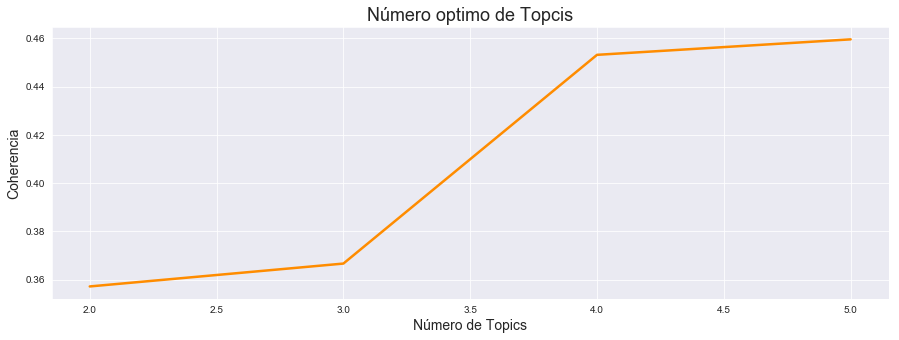

In [34]:
warnings.filterwarnings('ignore')

coherence_list = []
model_list = []
topics_range = range(2,6,1)
for num_topics in topics_range:
    lda_model = LdaModel(corpus=bow_corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         chunksize=5,
                         passes=20,
                         alpha="auto",
                         eta="auto",
                         per_word_topics=True)
    model_list.append(lda_model)
    
    coherence_model = CoherenceModel(model=lda_model, texts=tokenize, dictionary=dictionary, coherence='c_v')
    coherence_list.append(coherence_model.get_coherence())
    
fig, ax = plt.subplots(figsize=(15,5))

ax = sns.lineplot(x=topics_range, y=coherence_list, color="darkorange", linewidth=2.5)

ax.set_title("Número optimo de Topics", fontsize=18)
ax.set_xlabel("Número de Topics", fontsize=14)
ax.set_ylabel("Coherencia", fontsize=14)

plt.show()

In [35]:
## Obtenemos el las palabras más representativas de cada topic escogiendo el modelo con mayor coherencia
lda_model_opt = model_list[np.argmax(coherence_list)]

for idx, topic in lda_model_opt.print_topics(-1):
    print('\nTopic: {} \nWord: {}'.format(idx, topic))


Topic: 0 
Word: 0.012*"island" + 0.008*"dead" + 0.008*"horror" + 0.008*"mystery" + 0.007*"kill" + 0.006*"question" + 0.006*"rick" + 0.005*"walk" + 0.005*"zombie" + 0.005*"answer"

Topic: 1 
Word: 0.022*"supergirl" + 0.018*"comic" + 0.015*"arrow" + 0.014*"flash" + 0.014*"superhero" + 0.014*"hero" + 0.013*"batman" + 0.013*"super" + 0.010*"superman" + 0.010*"villain"

Topic: 2 
Word: 0.010*"doctor" + 0.010*"comedy" + 0.006*"mother" + 0.005*"humor" + 0.005*"joke" + 0.004*"netflix" + 0.004*"office" + 0.004*"relationship" + 0.004*"hilarious" + 0.004*"robin"

Topic: 3 
Word: 0.028*"dexter" + 0.027*"sherlock" + 0.018*"holmes" + 0.013*"saul" + 0.011*"crime" + 0.010*"watson" + 0.009*"killer" + 0.008*"detective" + 0.008*"police" + 0.006*"serial"

Topic: 4 
Word: 0.006*"game" + 0.006*"brother" + 0.005*"fargo" + 0.004*"event" + 0.004*"throne" + 0.004*"masterpiece" + 0.003*"claire" + 0.003*"fight" + 0.003*"cinematography" + 0.003*"band"


In [36]:
warnings.filterwarnings('ignore')

## Visualizamos de forma interactiva los topics obtenidos
vis = pyLDAvis.gensim.prepare(lda_model_opt, bow_corpus, dictionary, mds='mmds')
pyLDAvis.display(vis)

        Documento
Topics           
0              14
1              13
2              40
3              14
4              18

Establecemos un umbral de 10 documentos que afecta a los topics: []


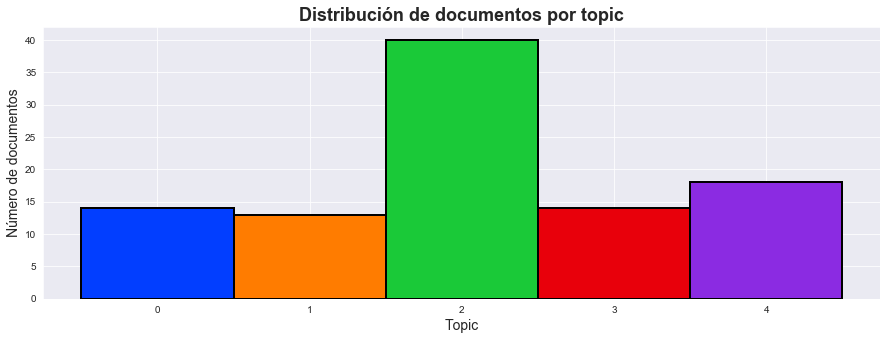

In [37]:
## Obtenemos el topic del documento
doc_topic = []
for i in range(0, len(bow_corpus)):
    topic = pd.DataFrame(lda_model_opt[bow_corpus[i]][0]).sort_values(by=1, ascending=False).values[0][0].astype(int)
    doc_topic.append(topic)

## Obtenemos el número de documento
num_doc = ["Doc " + str(i+1) for i in range(len(bow_corpus))]

## Generamos un dataframe con los datos
data_doc_topic = pd.DataFrame({"Documento":num_doc, "Topics":doc_topic})

## Obtenemos un conteo del número de documento por topic y calculamos un umbral mínimo 
doc_topic_count = data_doc_topic.groupby("Topics")["Documento"].aggregate("count")
print(pd.DataFrame(doc_topic_count))

threshold = 10
out_thrs = doc_topic_count[doc_topic_count < threshold].index.tolist()

print("\nEstablecemos un umbral de {threshold} documentos que afecta a los topics: {out_thrs}".format(threshold=threshold, out_thrs=out_thrs))

## Agrupamos las series por debajo del umbral con aquel topic que menos series tiene
index_list = []
for j in out_thrs:
    ind = data_doc_topic[data_doc_topic["Topics"] == j].index.tolist()
    [index_list.append(k) for k in ind]
    
    new_topic_list = doc_topic_count.sort_values(ascending=True).index.tolist()
    for l in new_topic_list:
        if l not in out_thrs:
            new_topic = l
            break
        else:
            continue
    
    print("El nuevo topic asignado es:", new_topic)
    data_doc_topic.loc[index_list, "Topics"] = new_topic
    
## Volvemos a obtener un conteo del número de documento por topic 
doc_topic_count = data_doc_topic.groupby("Topics")["Documento"].aggregate("count")
        
## Visualizamos la distribución de topics a lo largo de todas las series  
fig, ax = plt.subplots(figsize=(15,5))
ax = plt.bar(doc_topic_count.index.astype(str), doc_topic_count, linewidth=2, width=1, edgecolor="black", color=sns.color_palette("bright"))

plt.title("Distribución de documentos por topic", fontsize=18, fontweight="bold")
plt.xlabel("Topic", fontsize=14)
plt.ylabel("Número de documentos", fontsize=14)

plt.show()

In [38]:
## Unimos los datos de las series con el topic obtenido para cada serie
data_series_topics = pd.concat([data_series, data_doc_topic.Topics.astype(str)], axis=1)

## Obtenemos la suma de valores NaN
miss_values = data_series_topics.isnull().sum()

## Calculamos el porcentaje equivalente a dichas sumas redondeando el resultado
miss_values_percent = (miss_values*100/len(data_series_topics)).round(2)

## Juntamos ambos calculos en una misma tabla
miss_values_table = pd.concat([miss_values,miss_values_percent], axis=1)

## Renombramos las columnas y filtramos las filas cuyo valor es distinto de 0 para su visualización
miss_values_table = miss_values_table.rename(columns={0:"Total de NaN", 1:"% de NaN"})
miss_values_table[miss_values_table.loc[:,"Total de NaN"] != 0]

,Total de NaN,% de NaN
imdb_ratings,1,1.0
Topics,1,1.0


In [39]:
## Eliminamos todas las filas que posean valores NaN.
data_series_topics = data_series_topics.dropna(axis=0)

## Contamos los posibles duplicados y los eliminamos
duplicated_rows = data_series_topics.duplicated().sum()   
if (duplicated_rows > 0):
    data_series_topics = data_series_topics.drop_duplicates().reset_index(drop=True)
    print("Número de filas duplicadas eliminadas:", duplicated_rows)
else:
    print("No se han encontrado filas duplicadas")

## Juntamos los datos de las series con los comentarios mediante el nombre de la url
data_total = data_series_topics.loc[:,["urls","Topics"]].merge(data, how='left', on="urls")

No se han encontrado filas duplicadas


In [40]:
## Guardamos los set de datos obtenidos
path = "../Datos/"

print("Tamaño del set de series con topics:", data_series_topics.shape)
print("Tamaño del set total:", data_total.shape)

data_series_topics.to_csv(path + "data_series_topics.csv", header=True, sep=";", index=False)
data_total.to_csv(path + "data_total.csv", header=True, sep="|", index=False)

print("\nSets de datos guardados")

Tamaño del set de series con topics: (98, 7)
Tamaño del set total: (42030, 14)

Sets de datos guardados


## Collaborative Filtering<a name="id6"></a>

In [41]:
## Cargamos los set de datos guardados
path = "../Datos/"

data_series_topics = pd.read_csv(path + "data_series_topics.csv", header=0, sep=";", dtype={"years_begins":str})
data_total = pd.read_csv(path + "data_total.csv", header=0, sep="|", dtype={"user_ratings": float})

print("Sets de datos cargados")

Sets de datos cargados


In [42]:
## Creamos una función para obtener las matrices de interacción item-user según el topic
def get_interaction_matrix(data, topic):
    if topic=="all":
        interaction_matrix = data.pivot_table(index=["users_names"], columns=["names"], values="users_ratings")
    else:
        interaction_matrix = data[data["Topics"]==topic].pivot_table(index=["users_names"], columns=["names"], values="users_ratings")
    
    return interaction_matrix

In [43]:
## Obtenemos la matriz de interacciones sin filtrar el topic
interaction_matrix = get_interaction_matrix(data_total, "all")
print("Tamaño de la matriz de interacciones:", interaction_matrix.shape)

## Calculamos como de sparse es la matriz de interacción
suma = []
[suma.append(i) for i in (interaction_matrix > 0).sum()]
sparsicity = (sum(suma)/interaction_matrix.size)*100

print("Sparsicity de la matriz de interacciones: {:.5}%".format(sparsicity))

Tamaño de la matriz de interacciones: (35042, 98)
Sparsicity de la matriz de interacciones: 1.2083%


In [44]:
## Creamos una función para obtener las matrices de similitud item-item según el topic
def get_similarity_matrix(interaction_matrix):
    
    ## Generamos una matriz de ceros
    cos_distance = np.zeros((interaction_matrix.shape[1], interaction_matrix.shape[1]))

    ## Iteramos sobre la matriz de interacciones item-usuario para obtener la distancia del coseno descartando valores NaN
    for i in range(0, interaction_matrix.shape[1]):
        u = interaction_matrix[interaction_matrix.columns[i]]
        for j in range(0, interaction_matrix.shape[1]):
            v = interaction_matrix[interaction_matrix.columns[j]]
            ind = []
            for k in range(0, len(u)):
                if (np.isnan(u[k]) or np.isnan(v[k])) == False:
                    ind.append(k)
                else:
                    continue
            cos_distance[i,j] = 1-distance.cosine(u[ind], v[ind]).round(4)

    similarity_matrix = pd.DataFrame(cos_distance, columns=interaction_matrix.columns, index= interaction_matrix.columns)
    similarity_matrix = similarity_matrix.replace(np.NaN, "0").astype("float64")
    
    return similarity_matrix

In [45]:
## Obtenemos la matriz de similitudes
similarity_matrix = get_similarity_matrix(interaction_matrix)
print("Tamaño de la matriz de similitudes:", similarity_matrix.shape)

## Calculamos como de sparse es la matriz de similitudes
suma = []
[suma.append(i) for i in (similarity_matrix > 0).sum()]
sparsicity = (sum(suma)/similarity_matrix.size)*100

print("Sparsicity de la matriz de similitudes: {:.5}%".format(sparsicity))

Tamaño de la matriz de similitudes: (98, 98)
Sparsicity de la matriz de similitudes: 69.034%


In [46]:
## Obtenemos un listado de los topics unicos
topic_list = data_total.Topics.unique().astype("int64").tolist()

## Aplicando las funciones creadas previamente obtenemos las matrices de similitud e interacción por topic
for i in topic_list:
    globals()['interaction_matrix_'+ str(i)] = get_interaction_matrix(data_total, i)
    globals()['similarity_matrix_'+ str(i)] = get_similarity_matrix(eval('interaction_matrix_%d'% (i)))

## Display and Result<a name="id7"></a>

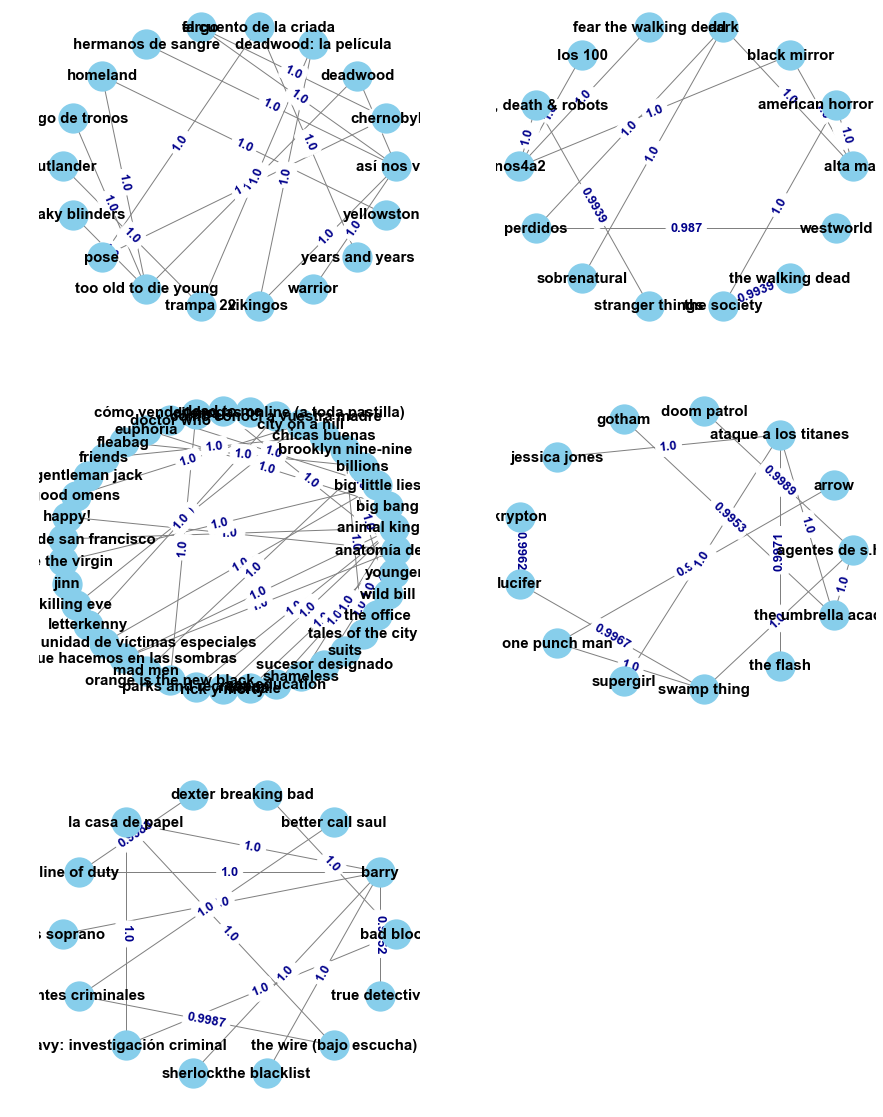

In [47]:
## Generamos una figura para representar a modo de grafo las diferentes recomendaciones
plt.figure(figsize=(15,20))

## Indicamos el path para guardar cada grafo en cada iteración
path = "../Datos/"

n=0
for i in topic_list:
    n+=1
    ## Generamos un grafo a partir del dataframe de similitudes
    G = nx.from_pandas_adjacency(eval('similarity_matrix_%d'% (i)))

    ## Designamos un diseño del grafo para visualizarlo comodamente
    pos = nx.circular_layout(G)

    ## Creamos un diccionario con los nombres de las series para añadir etiquetas a los nodos
    labels = eval('similarity_matrix_%d'% (i)).columns.values
    G = nx.relabel_nodes(G, dict(zip(range(len(labels)), labels)))

    ## Aplicamos el algoritmo del Arbol de Expansión Máximo
    G = nx.maximum_spanning_tree(G, algorithm='kruskal', weight="weight", ignore_nan=False)

    ## Obtenemos las similitudes de los vertices
    edge_labels = nx.get_edge_attributes(G, "weight")

    values = []
    [values.append(round(j,4)) for j in list(edge_labels.values())]
    
    edge_labels = dict(zip(edge_labels.keys(), values))

    ## Visualizamos el grafo final    
    plt.subplot(int(np.ceil(len(topic_list)/2)*100+20+n))
    nx.draw(G,
            pos,
            with_labels=True,
            font_size=15,
            font_weight='bold',
            node_color='skyblue',
            node_size=800,
            edge_color='grey',
            linewidths=2)

    nx.draw_networkx_edge_labels(G,
                                 pos,
                                 edge_labels=edge_labels,
                                 font_color='darkblue',
                                 font_size=13,
                                 font_weight='bold')
    
    ## Guardamos el grafo obtenido
    nx.write_edgelist(G, path=path+"grafo_topic_"+str(i), delimiter=";")

In [48]:
## Generamos una función para obtener la recomendación final que observará el usuario
def Recomendation(serie):
    
    data_series_topics = pd.read_csv(path + "data_series_topics.csv", header=0, sep=";", dtype={"years_begins":str})

    topic = int(data_series_topics[data_series_topics.names==serie].Topics)

    G = nx.read_edgelist(path=path+"grafo_topic_"+str(topic), delimiter=";")

    EG = nx.ego_graph(G, n=serie, radius=2, center=True, undirected=True, distance="weight")
    ego_node=nx.ego_graph(G, n=serie, radius=0)

    fig, ax = plt.subplots(figsize=(15,10))
    pos = nx.spring_layout(EG)

    ax = nx.draw(EG,
                 pos,
                 with_labels=True,
                 font_size=15,
                 font_weight='bold',
                 node_color='lime',
                 node_size=800,
                 edge_color='grey',
                 linewidths=2)

    ax = nx.draw_networkx_nodes(ego_node, pos=pos, radius=0, node_size=900, node_color='red')
    
    plt.show()

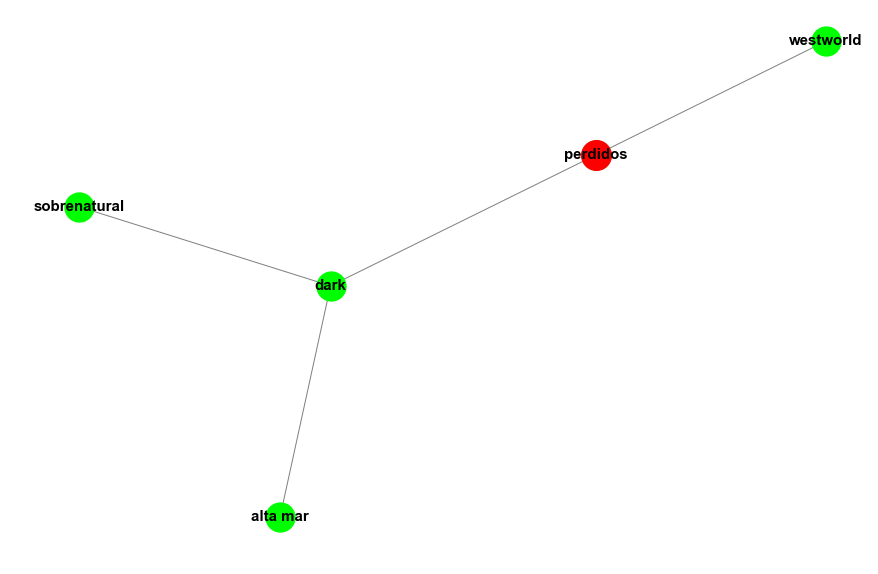

In [76]:
## Usamos la función de recomendación con un ejemplo
Recomendation("perdidos")

## Conclusion<a name="id8"></a>

---

Throughout this Jupyter Notebook we have observed the different steps to follow to build a Similarity Recommendation System through natural language processing and the use of collaborative filtering techniques, starting with obtaining the data and ending with a visualization in graph form of the recommendation to the user. In this case we have used the top 100 most popular series on the IMDb page, however this recommendation structure can be applied to many other areas with the potential of being able to make a recommendation to a user who does not want to interact with you explicitly. Thanks to this type of generative algorithms in conjunction with the prevailing techniques in the market, such as collaborative filtering, we can explore this kind of technology as an anchor point where new users could be captured, having an impact on the future benefit of the company.